In [33]:
from tkinter.font import names

from IPython.core.debugger import prompt
from langchain.chains.qa_with_sources.stuff_prompt import template
from langchain_openai import ChatOpenAI
from typing import TypedDict , List
from langgraph.graph import StateGraph, START, END
from langchain.prompts import Prompt ,PromptTemplate
from langchain.schema import HumanMessage, AIMessage , SystemMessage
from IPython.display import display, Image

from langgraph_notebook_examples.studio.chatbot import workflow
from langgraph_notebook_examples.studio.mul_tool import sys_msg

In [6]:
from dotenv import load_dotenv
load_dotenv("H:\My_LangGraph_toturial\.env")
import os
open_ai_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = open_ai_key

In [34]:
class TextAnalysisState(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str


In [35]:
llm : ChatOpenAI = ChatOpenAI(model_name="gpt-3.5-turbo", max_tokens=200)

In [36]:

def classification_node(state: TextAnalysisState) -> TextAnalysisState:
    """
    This function will classify the given text and return the classification of the text.
    :param state:
    :return: one of the categories: News, Blog, Research, or Other.
    """
    template = "Classify the following text into one of the categories: News, Blog, Research, or Other.\n\n Text: {text}"
    prompt = PromptTemplate.from_template(template)

    sys_msg = "You are an AI assistant designed to classify text into predefined categories. Your task is to analyze the given text and assign it to one of the following categories: [News, Blog, Research, or Other]. Please provide your classification as a single word or phrase corresponding to the most appropriate category. If you're unsure, respond with Other. Do not explain your reasoning or provide additional commentary."

    messages = [HumanMessage(content = prompt.format(text = state['text']))]
    sys = [SystemMessage(content = sys_msg)]
    final_message = messages + sys
    classification = llm.invoke(final_message).content.strip()
    return {"classification": classification}

def entity_extraction_node(state: TextAnalysisState) -> TextAnalysisState:
    """
    This function will extract entities from the given text and return the list of entities.
    :param state:
    :return: [Person, Organization, Location]

    """
    template = "Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\n  Entities:"

    prompt = PromptTemplate.from_template(template)

    sys_msg = "You are an AI assistant designed to extract entities from text. Your task is to analyze the given text and identify any entities that are mentioned. Entities can be people, organizations, locations. Please provide a list of entities that you find in the text. If you're unsure, you can respond with 'None'. Do not explain your reasoning or provide additional commentary."

    messages = [HumanMessage(content = prompt.format(text = state['text']))]
    sys = [SystemMessage(content = sys_msg)]
    final_message = messages + sys
    entities = llm.invoke(final_message).content.strip().split(",")
    return {"entities": entities}

def summarization_node(state: TextAnalysisState) -> TextAnalysisState:
    ''' Summarize the text in one short sentence '''

    template = "Summarize the following text in one short sentence.\n\nText:{text}\n\n Summary:"
    prompt = PromptTemplate.from_template(template)

    message = HumanMessage(content=prompt.format(text=state["text"]))
    summary = llm.invoke([message]).content.strip()
    return {"summary": summary }

workflow = StateGraph(TextAnalysisState)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction", entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.add_edge(START, "classification_node")
workflow.add_edge("classification_node", "entity_extraction")
workflow.add_edge("entity_extraction", "summarization_node")
workflow.add_edge("summarization_node", END)

graph = workflow.compile()




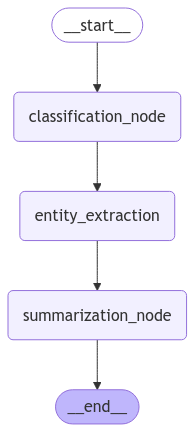

In [37]:
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [38]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""
state_input = {"text": sample_text}
result = graph.invoke(state_input)

result

{'text': '\nOpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.\nadditionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.\n',
 'classification': 'News',
 'entities': ['OpenAI', ' GPT-4', ' GPT-3'],
 'summary': 'OpenAI has revealed the GPT-4 model, a large multimodal model with human-level performance on professional benchmarks, aimed at improving AI alignment and safety, and expected to be more efficient and scalable than GPT-3.'}